<a href="https://colab.research.google.com/github/shima2920/data-analysis/blob/main/SIGNATE_Census_20210209_lightGBM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#from tqdm import tqdm
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder#Label Encoding
from sklearn.model_selection import train_test_split
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import mean_squared_error
import lightgbm as lgb
#import optuna.integration.lightgbm as lgb #LightLGBのハイパーパラメータチューニングモジュールであるOptunaをimport
import lightgbm as lgb_original
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
import xgboost as XGBClassifier
from sklearn.model_selection import train_test_split

from keras.layers import Dense, Dropout #Dense : ニューラルネットの層を定義？
from keras.models import Sequential# 複雑なニューラルネットワークモデルを簡略化するためのモデルの一つであるSequentialモデル
from sklearn.preprocessing import StandardScaler #標準化



#Validation
from sklearn.metrics import log_loss, accuracy_score
from sklearn.model_selection import KFold


#イテレータ, ループ処理を実行してくれる
import itertools

pd.set_option("display.max_rows", 10000)
pd.set_option('display.max_columns', 1000)
%matplotlib inline

## Import train and test data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample_submission = pd.read_csv('sample_submit.csv')

# Checking the data

In [3]:
print('Training Features shape: ', train.shape)
print('Testing Features shape: ', test.shape)

Training Features shape:  (10137, 13)
Testing Features shape:  (5100, 12)


# Label encoding

In [4]:
for c in train.columns:
    if train[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train[c].values)) 
        train[c] = lbl.transform(list(train[c].values))
        
for c in test.columns:
    if test[c].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(test[c].values)) 
        test[c] = lbl.transform(list(test[c].values))

In [6]:
train.head()

,index,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,native-country,Y
0,322,21,3,132652,13,10,1,1,3,2,0,2,0.0
1,11968,29,3,132652,10,9,1,1,1,2,0,2,0.0
2,10868,19,3,132652,9,13,3,8,1,2,0,2,0.0
3,3394,17,3,132652,10,9,3,2,3,2,1,2,0.0
4,15993,47,3,132652,13,10,2,2,0,2,1,2,0.0


#Split Train data

In [7]:
x_train = train.drop(['Y'], axis = 1)
y_train = train['Y']

# Split Train data int train and test data 

In [8]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(x_train,y_train,test_size=0.2,random_state=42)

# LightGBM

In [10]:
#LightGBM用のデータ作成
lgb_train = lgb.Dataset(x_train, y_train)
lgb_valid = lgb.Dataset(x_test, y_test, reference=lgb_train)

In [11]:
# to record eval results for plotting
evals_result = {} 

In [12]:
#LightGBM用のハイパーパラメータ設定
lgb_params = {
    'task': 'train',
    'boosting_type': 'gbdt',#Boostingアルゴリズム。LightGBMのみで使用可能なParameter。基本は勾配ぶースティングをしたいのでデフォルトのgdbtを使用する。
    'objective': 'binary',# regression(回帰) : 絶対値誤差関数(L1)ならばmae, 2乗誤差関数(L2)ならばmseと指定, binary(二値分類, ラベルは0,1) : binary_logloss(クロスエントロピー)とbinary_error(正答率)の2つ,multiclass(多クラス分類) : metricとしては、multi_logloss(softmax関数), multi_error(正答率))
    'metric': 'auc',
    'num_leaves': 20,#木にある分岐の個数．デフォルトは31, 大きくすると精度は上がるが過学習が進む
    'max_depth': 10,#木構造の深さを限定するための変数．データが少ないときに過学習を防ぐために設定する．デフォルト値は-1で0以下の値は制限なしを意味する．
    'learning_rate': 0.05,#学習率。デフォルトは0.1
    'feature_fraction': 0.9,#学習の高速化と過学習の抑制に使用される．データの特徴量のfeature_fraction * 100 % だけ使用する．
    'min_data_in_leaf':4,#大きくすることでデータと分岐が1対1対応することを防ぎ，結果として過学習を抑制する．
    'verbose':50
}


In [13]:
model = lgb.train(lgb_params,
                  lgb_train,
                  valid_sets=lgb_valid,#early stopping機能を実行するために、評価用データを渡す
                  num_boost_round=10000,
                  evals_result=evals_result,
                  early_stopping_rounds=100,
                  verbose_eval=10
                  )


Training until validation scores don't improve for 100 rounds.
[10]	valid_0's auc: 0.894103
[20]	valid_0's auc: 0.89594
[30]	valid_0's auc: 0.897532
[40]	valid_0's auc: 0.898903
[50]	valid_0's auc: 0.899167
[60]	valid_0's auc: 0.89983
[70]	valid_0's auc: 0.900096
[80]	valid_0's auc: 0.900963
[90]	valid_0's auc: 0.901738
[100]	valid_0's auc: 0.901815
[110]	valid_0's auc: 0.901834
[120]	valid_0's auc: 0.901977
[130]	valid_0's auc: 0.901999
[140]	valid_0's auc: 0.90198
[150]	valid_0's auc: 0.901818
[160]	valid_0's auc: 0.901919
[170]	valid_0's auc: 0.902009
[180]	valid_0's auc: 0.901912
[190]	valid_0's auc: 0.901943
[200]	valid_0's auc: 0.901512
[210]	valid_0's auc: 0.90148
[220]	valid_0's auc: 0.901179
[230]	valid_0's auc: 0.900944
[240]	valid_0's auc: 0.900682
Early stopping, best iteration is:
[144]	valid_0's auc: 0.902141


In [14]:
# validデータのpredict
y_test_pred = model.predict(x_test, num_iteration=model.best_iteration)#num_iteration : 決定木(予測木)の数。 

In [16]:
y_test_pred

array([0.54245936, 0.00773899, 0.08130506, ..., 0.16651207, 0.00249897,
       0.00567641])

# Feature importance


Feature names: ['index', 'age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']

Calculate feature importances...
Feature importances: [595, 541, 148, 63, 202, 320, 182, 415, 155, 61, 31, 23]
Plot feature importances...


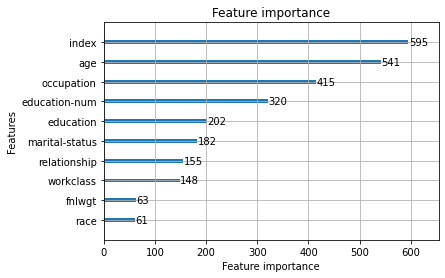

In [17]:
# print feature names
print('\nFeature names:', model.feature_name())

print('\nCalculate feature importances...')

# feature importances
print('Feature importances:', list(model.feature_importance()))

#print('Plot metrics during training...')
#ax = lgb.plot_metric(evals_result, metric='l2')
#plt.show()

print('Plot feature importances...')
ax = lgb.plot_importance(model, max_num_features=10)
plt.show()

#Predict Test data

In [19]:
y_pred = model.predict(test, num_iteration=model.best_iteration)

In [21]:
y_pred

array([0.39586914, 0.13768148, 0.06338088, ..., 0.03297628, 0.21840239,
       0.2211971 ])

# Submission

In [30]:
sub = pd.DataFrame(pd.read_csv('test.csv')['index'])
sub['Y'] = list(map(float, y_pred))
sub.Y = sub.Y.apply(lambda x : 1 if x > 0.49 else 0)
sub.to_csv('submission_yshimamu_lightGBM_20210210.csv', index=False)

In [31]:
sub.Y

0       0
1       0
2       0
3       0
4       0
5       0
6       0
7       0
8       0
9       0
10      0
11      0
12      0
13      0
14      0
15      0
16      0
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24      0
25      0
26      0
27      0
28      0
29      0
30      0
31      1
32      0
33      1
34      0
35      0
36      0
37      0
38      0
39      0
40      0
41      0
42      0
43      0
44      0
45      0
46      0
47      0
48      1
49      0
50      0
51      0
52      0
53      0
54      0
55      0
56      0
57      0
58      0
59      1
60      0
61      0
62      0
63      0
64      1
65      0
66      0
67      0
68      0
69      0
70      0
71      0
72      0
73      0
74      0
75      0
76      0
77      0
78      0
79      0
80      0
81      0
82      0
83      0
84      0
85      0
86      0
87      0
88      0
89      0
90      0
91      0
92      0
93      0
94      0
95      0
96      0
97      0
98      0
99      0


In [32]:
sub.head(100)

,index,Y
0,3873,0
1,3625,0
2,3028,0
3,13814,0
4,15398,0
5,13244,0
6,2516,0
7,3008,0
8,2619,0
9,2525,0
